In this notebook we explore more about eye tracking data analysis

In [1]:
# Derived from:
#     https://www.axonlab.org/hcph-sops/data-management/eyetrack-qc
# Load the autoreload extension
%load_ext autoreload
# Set autoreload to update the modules every time before executing a new line of code
%autoreload 2

%matplotlib inline
from pathlib import Path
import json
import ppjson
from importlib import reload  # For debugging purposes

import numpy as np
import pandas as pd

import eyetrackingrun as et

from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from write_bids_yiwei import EyeTrackingRun, write_bids, write_bids_from_df

In [17]:
# D:\Eye_Dataset\Sub001\230928_anatomical_MREYE_study\ET_EDF
BIDS_PATH = Path("D:\\Eye_Dataset\\Sub001\\230928_anatomical_MREYE_study\\ET_EDF")
FILE_NAME ='JB2'
mode = 'T2'
session = "004" #can be a string to be defined when required
tsv_name = f"{FILE_NAME}.tsv.gz"
gif_name = f'{FILE_NAME}.gif'


In [18]:
# Read in tsv.gz file
# Naming convension can be modified later
# recording_file = BIDS_PATH / "sub-001" / f"ses-{session}" / "dwi" / f"sub-001_ses-{session}_acq-highres_dir-RL_recording-eyetrack_physio.tsv.gz"
recording_file = BIDS_PATH / tsv_name
print(f'recording_file: {recording_file}')
recording = pd.read_csv(
    recording_file,
#     sep=r"\s+",
    sep="\t",
    na_values="n/a",
)
recording.head()
print(f'recording len: {len(recording)}')
metadata = json.loads((
    recording_file.parent
    / recording_file.name.replace(".tsv.gz", ".json")
).read_text())
print(f'meta_data: {metadata}')

recording_file: D:\Eye_Dataset\Sub001\230928_anatomical_MREYE_study\ET_EDF\JB2.tsv.gz
recording len: 1106537
meta_data: {'AverageCalibrationError': [0.56], 'CalibrationCount': 1, 'CalibrationLog': [[1973607, '>>>>>>> CALIBRATION (HV5,P-CR) FOR RIGHT: <<<<<<<<<'], [1973608, 'Calibration points:'], [1973608, '-10.5, -49.1         0,      0'], [1973608, '-10.5, -71.3         0,  -2457'], [1973608, '-10.1, -29.2         0,   2457'], [1973608, '-43.8, -49.2     -3474,      0'], [1973608, '22.8, -51.0      3474,      0'], [1973608, 'eye check box: (L,R,T,B)\n\t  -50    29   -76   -25'], [1973608, 'href cal range: (L,R,T,B)\n\t-5211  5211 -3686  3686'], [1973608, 'Cal coeff:(X=a+bx+cy+dxx+eyy,Y=f+gx+goaly+ixx+jyy)\n   5.882e-05  104.29 -1.0835 -0.0051479 -0.062928 \n   4.4115e-05  3.0779  117.27  0.097731  0.2935'], [1973608, 'Prenormalize: offx, offy = -10.544 -49.144'], [1973608, 'Gains: cx:104.313 lx:104.623 rx:104.587'], [1973608, 'Gains: cy:145.928 ty:108.256 by:138.042'], [1973608, 'Res

# Metadata and calibration

We always run a calibration before it is started. As a result, we will typically see the metadata corresponding to calibration on this particular run.

Now, let's print out the contents of the BIDS' sidecar JSON corresponding to the DWI in this session.

In [19]:
recording

,Unnamed: 0,eye1_x_coordinate,eye1_y_coordinate,eye1_pupil_size,eye1_pupil_x_coordinate,eye1_pupil_y_coordinate,eye1_href_x_coordinate,eye1_href_y_coordinate,fast_raw_x_velocity,screen_ppdeg_x_coordinate,screen_ppdeg_y_coordinate,timestamp,eye1_fixation,eye1_saccade,eye1_blink
0,0,NaN,NaN,NaN,-32768.0,-32768.0,-7936.0,-7936.0,4.591495e-41,29.799999,32.799999,2007985,0,0,0
1,1,NaN,NaN,NaN,-32768.0,-32768.0,-7936.0,-7936.0,4.591495e-41,29.799999,32.799999,2007986,0,1,1
2,2,NaN,NaN,NaN,-32768.0,-32768.0,-7936.0,-7936.0,4.591495e-41,29.799999,32.799999,2007987,0,1,1
3,3,NaN,NaN,NaN,-32768.0,-32768.0,-7936.0,-7936.0,4.591495e-41,29.799999,32.799999,2007988,0,1,1
4,4,NaN,NaN,NaN,-32768.0,-32768.0,-7936.0,-7936.0,4.591495e-41,29.799999,32.799999,2007989,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106532,1106532,381.500000,296.299988,2185.0,-1536.0,-6175.0,-182.0,-35.0,-6.149000e+03,26.500000,26.500000,3114517,1,0,0
1106533,1106533,381.600006,296.899994,2181.0,-1535.0,-6170.0,-181.0,-30.0,-6.149000e+03,26.500000,26.500000,3114518,1,0,0
1106534,1106534,381.700012,296.899994,2180.0,-1533.0,-6169.0,-179.0,-29.0,-6.149000e+03,26.500000,26.500000,3114519,1,0,0
1106535,1106535,381.299988,297.100006,2183.0,-1538.0,-6167.0,-184.0,-28.0,-6.149000e+03,26.500000,26.500000,3114520,1,0,0


In [20]:
t_axis = (
    recording.timestamp.values - recording.timestamp[0]
) / metadata["SamplingFrequency"]


In [21]:
print(metadata["Columns"])
recording = recording.rename(
        columns={
            f"eye1_pupil_size": f"pupil_size",
            f"eye1_fixation": f"fixation",
            f"eye1_saccade": f"saccade",
            f"eye1_blink": f"blink",
            f"eye1_x_coordinate": f"x_coordinate", 
            f"eye1_y_coordinate": f"y_coordinate"         
        }
    )

metadata["Columns"] = recording.columns.tolist()
print(metadata["Columns"])

['eye1_x_coordinate', 'eye1_y_coordinate', 'eye1_pupil_size', 'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate', 'eye1_href_x_coordinate', 'eye1_href_y_coordinate', 'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp', 'eye1_fixation', 'eye1_saccade', 'eye1_blink']
['Unnamed: 0', 'x_coordinate', 'y_coordinate', 'pupil_size', 'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate', 'eye1_href_x_coordinate', 'eye1_href_y_coordinate', 'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp', 'fixation', 'saccade', 'blink']


In [22]:
recording.columns

Index(['Unnamed: 0', 'x_coordinate', 'y_coordinate', 'pupil_size',
       'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate',
       'eye1_href_x_coordinate', 'eye1_href_y_coordinate',
       'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate',
       'screen_ppdeg_y_coordinate', 'timestamp', 'fixation', 'saccade',
       'blink'],
      dtype='object')

Check the pupil area

In [23]:
check_pupil = False
if check_pupil:
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )

    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]");

    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )
    plt.title("Zoom In - Pupil Area")
    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]")
    # JB1 (100, 150)
    plt.xlim((100, 150))

Check the eye events:

 - Blink
    
- Saccade
    
- Fixation

Check blinking

(100.0, 150.0)

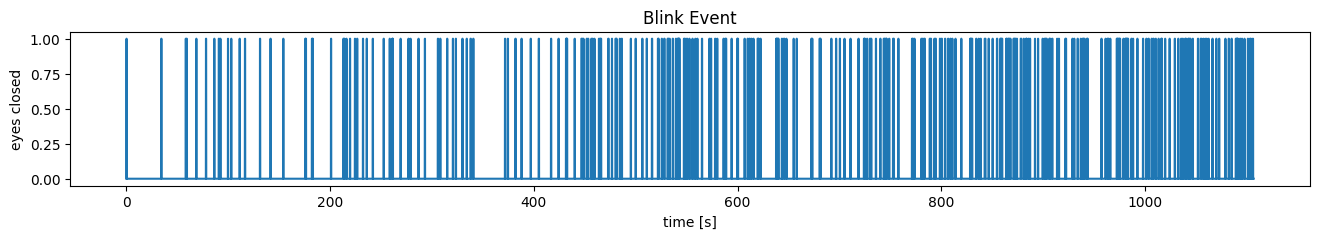

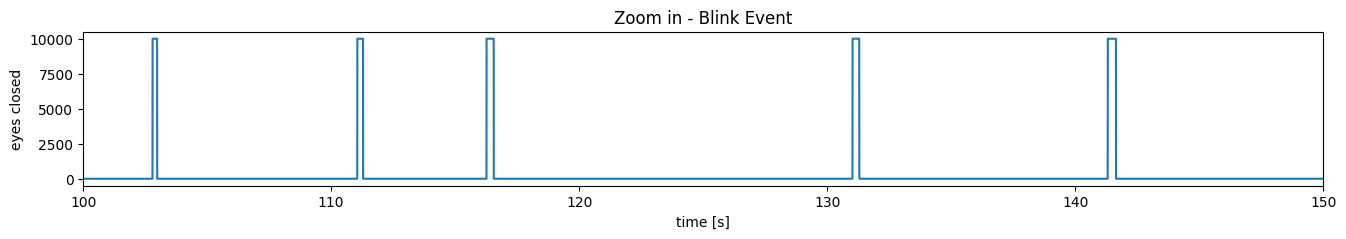

In [24]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["blink"].values,
)
plt.title("Blink Event")
plt.xlabel("time [s]")
plt.ylabel("eyes closed");

fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["blink"].values * 10000,
)
plt.xlabel("time [s]")
plt.ylabel("eyes closed")
plt.title("Zoom in - Blink Event")
plt.xlim((100, 150))

In [25]:
plot_pupil_blink = False
if plot_pupil_blink:
    fig = plt.figure(figsize=(16, 2))

    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )

    plt.plot(
        t_axis,
        recording["blink"].values * 5000,
    )

    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]")
    plt.xlim((200, 220))
    plt.title('Pupil area and blinking')

    print(f'At this time, since blinking is detected, we cannot get clear pupil area ?')

Check saccading

(100.0, 150.0)

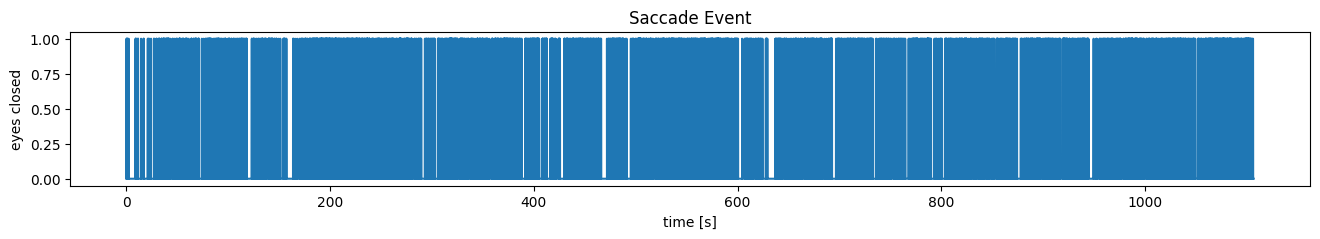

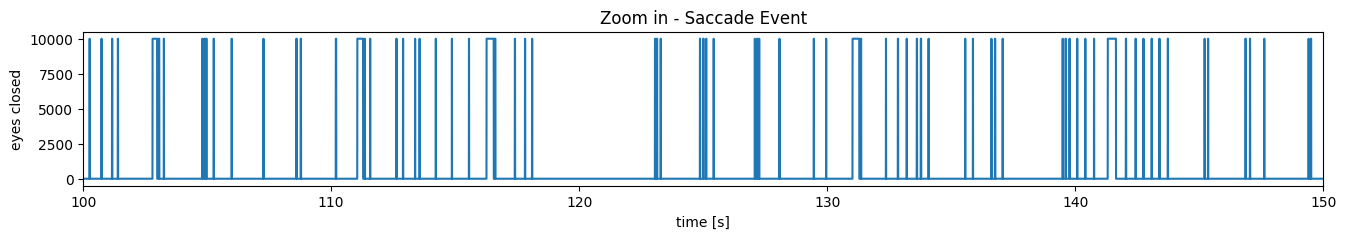

In [26]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["saccade"].values,
)
plt.title("Saccade Event")
plt.xlabel("time [s]")
plt.ylabel("eyes closed");

fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["saccade"].values * 10000,
)
plt.xlabel("time [s]")
plt.ylabel("eyes closed")
plt.title("Zoom in - Saccade Event")
plt.xlim((100, 150))

In [27]:
plot_pupil_saccade = False

if plot_pupil_saccade:
    fig = plt.figure(figsize=(16, 2))

    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )

    plt.plot(
        t_axis,
        recording["saccade"].values * 5000,
    )

    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]")
    plt.xlim((200, 220))
    plt.title('Pupil area and saccading')
    print(f'At this time, since blinking is detected, we cannot get clear pupil area ?')

In [28]:
plot_x_saccade = False
if plot_x_saccade:
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["x_coordinate"].values,
    )

    plt.plot(
        t_axis,
        recording["saccade"].values * 1000,
    )
    plt.xlim((200, 220))

Check fixation

Text(0.5, 1.0, 'Y coordinate of gazing with fixation')

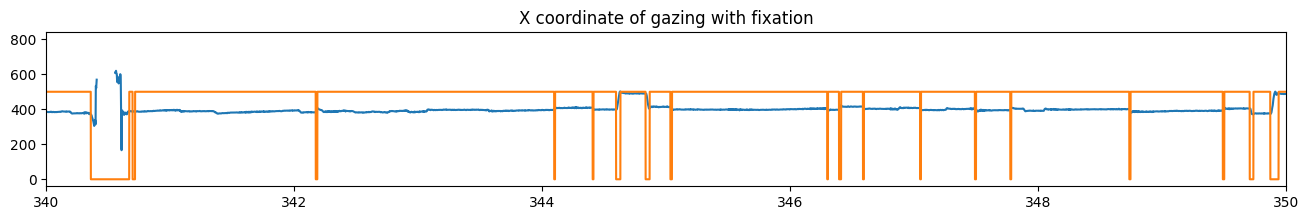

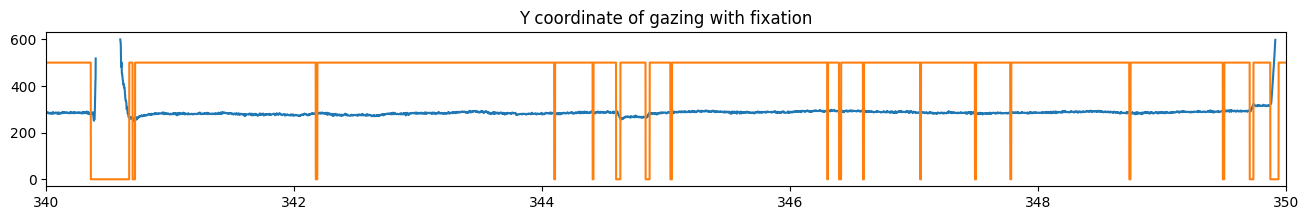

In [29]:
# Fixation
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["x_coordinate"].values,
)

plt.plot(
    t_axis,
    recording["fixation"].values * 500,
)
plt.xlim((340, 350))
plt.title('X coordinate of gazing with fixation')

fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["y_coordinate"].values,
)

plt.plot(
    t_axis,
    recording["fixation"].values * 500,
)
plt.xlim((340, 350))
plt.title('Y coordinate of gazing with fixation')

The analysis did not reveal a strong correlation between pupil size and saccade or fixation events.

The coordinate sequence is stable during fixation, we should extract the data in the event.

## T1-weighted 

- name psychopy and ET data: JB1

- duration of the protocol: 720sec (12 min)

- Our protocol (p178 6:02 min + 15.03s + 05:57 min)

- differences between the two sequence: 15.03 sec

- ET calibration: 5 points

## T2-weighted 

- name psychopy and ET data: JB2

- duration of the protocol: 1105sec (ca. 18 min)

- Our protocol (p178 10:42 min + 7.15s + 07:32 min)

- differences between the two sequence: 

- ET calibration: 5 points


# Data Cleaning

- Seperate the two phases of sequences
- Extract the X Y coordinates
- Eliminate the blinking and non-fixation area
- Design some criteria for cleaning the noise data
    - Visual angle
    - Heat maps
    - Fixation algorithm (literature review)

### Seperate the two phases of sequences

In [30]:
# Duration setting according to the protocol (in sec)

T1_LIBRE = 6*60+2
T1_GAP = 15.03
T1_VIBE = 5*60+57

T2_LIBRE = 10*60+42
T2_GAP = 7.15
T2_TSE = 7*60+32

length_T1 = metadata['SamplingFrequency']*(T1_LIBRE+T1_GAP+T1_VIBE)
print(f"The length of T1 should be: {length_T1}")
length_T2 = metadata['SamplingFrequency']*(T2_LIBRE+T2_GAP+T2_TSE)
print(f"The length of T2 should be: {length_T2}")

The length of T1 should be: 734030.0
The length of T2 should be: 1101150.0


In [31]:
size = (
    metadata["ScreenAOIDefinition"][1][1],
    metadata["ScreenAOIDefinition"][1][3],
)

coor_data = recording[["x_coordinate", "y_coordinate"]]
print(f"Extract X Y coordinates from recording: {len(coor_data)}")

coor_data = coor_data[coor_data.x_coordinate.notna() & coor_data.y_coordinate.notna()]
coor_recording = recording[recording.x_coordinate.notna() & recording.y_coordinate.notna()]
coor_data.reset_index(drop=True, inplace=True)
coor_recording.reset_index(drop=True, inplace=True)
print(f"Eliminating nan values: {len(coor_data)}")
print(f'len of coor_data {len(coor_data)} should be equal to len of coor_recording {len(coor_recording)}')

Extract X Y coordinates from recording: 1106537
Eliminating nan values: 1046726
len of coor_data 1046726 should be equal to len of coor_recording 1046726


set start margin as 0
642000
397576


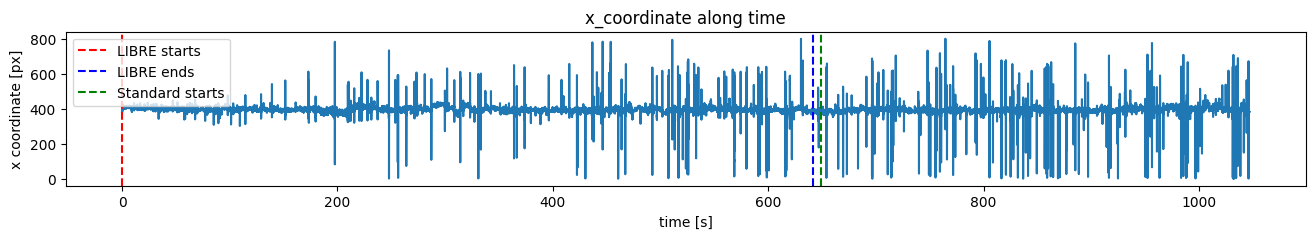

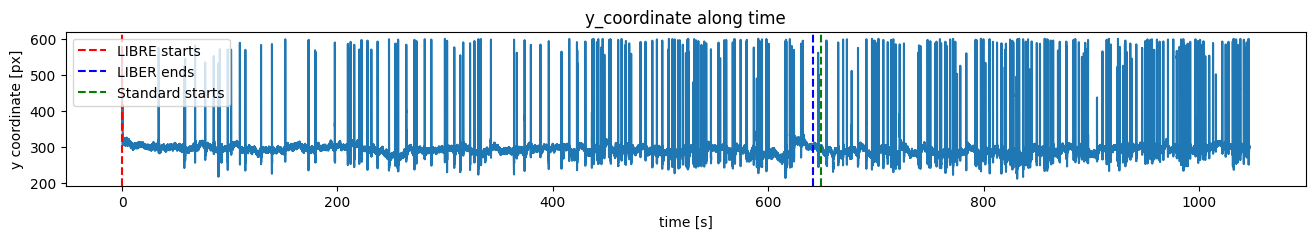

In [32]:
start_margin = int(0.0*metadata['SamplingFrequency'])
if mode == 'T1':
    print(f"set start margin as {start_margin}")
    T1_LIBRE_sample = T1_LIBRE*metadata['SamplingFrequency']
    T1_GAP_sample = T1_GAP*metadata['SamplingFrequency']
    T1_VIBE = len(coor_data) - T1_LIBRE_sample - T1_GAP_sample
else:
    print(f"set start margin as {start_margin}")
    T2_LIBRE_sample = T2_LIBRE*metadata['SamplingFrequency']
    T2_GAP_sample = T2_GAP*metadata['SamplingFrequency']
    T2_TSE = len(coor_data) - T2_LIBRE_sample - T2_GAP_sample
    


t_axis_xy = (
    coor_data.index 
) / metadata["SamplingFrequency"]

# x coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    coor_data["x_coordinate"].values,
)

if mode == 'T1':
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T1_LIBRE_sample+start_margin)/metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBRE ends')
    plt.axvline(x=(T1_LIBRE_sample+start_margin+T1_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
else:
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T2_LIBRE_sample+start_margin)/metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBRE ends')
    plt.axvline(x=(T2_LIBRE_sample+start_margin+T2_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
    
plt.title("x_coordinate along time")
plt.xlabel("time [s]")
plt.ylabel("x coordinate [px]")
plt.legend()

# y coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    coor_data["y_coordinate"].values,
)
if mode == "T1":
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T1_LIBRE_sample+start_margin)/ metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBER ends')
    plt.axvline(x=(T1_LIBRE_sample+start_margin+T1_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
else:
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T2_LIBRE_sample+start_margin)/ metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBER ends')
    plt.axvline(x=(T2_LIBRE_sample+start_margin+T2_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
    
plt.title("y_coordinate along time")
plt.xlabel("time [s]")
plt.ylabel("y coordinate [px]")
plt.legend()

if mode == 'T1':
    coor_data_LIBRE = coor_data[start_margin:int(T1_LIBRE_sample)] 
    coor_recording_LIBRE = coor_recording[start_margin:int(T1_LIBRE_sample)] 
    coor_data_STANDARD = coor_data[int(T1_LIBRE_sample+start_margin+T1_GAP_sample):] 
    coor_recording_STANDARD = coor_recording[int(T1_LIBRE_sample+start_margin+T1_GAP_sample):] 
else:
    coor_data_LIBRE = coor_data[start_margin:int(T2_LIBRE_sample)] 
    coor_recording_LIBRE = coor_recording[start_margin:int(T2_LIBRE_sample)] 
    coor_data_STANDARD = coor_data[int(T2_LIBRE_sample+start_margin+T2_GAP_sample):] 
    coor_recording_STANDARD = coor_recording[int(T2_LIBRE_sample+start_margin+T2_GAP_sample):] 

print(len(coor_data_LIBRE))
print(len(coor_data_STANDARD))

### Eliminating blinking

After eliminating blinking: 
len of coor_data_LIBRE 626215       should be equal to len of coor_recording 626215
After eliminating blinking: 
len of coor_data_STANDARD 379934       should be equal to len of coor_recording 379934


<AxesSubplot:title={'center':'STANDARD: The gaze from the beginning to the end'}, xlabel='x coordinate [pixels]', ylabel='y coordinate [pixels]'>

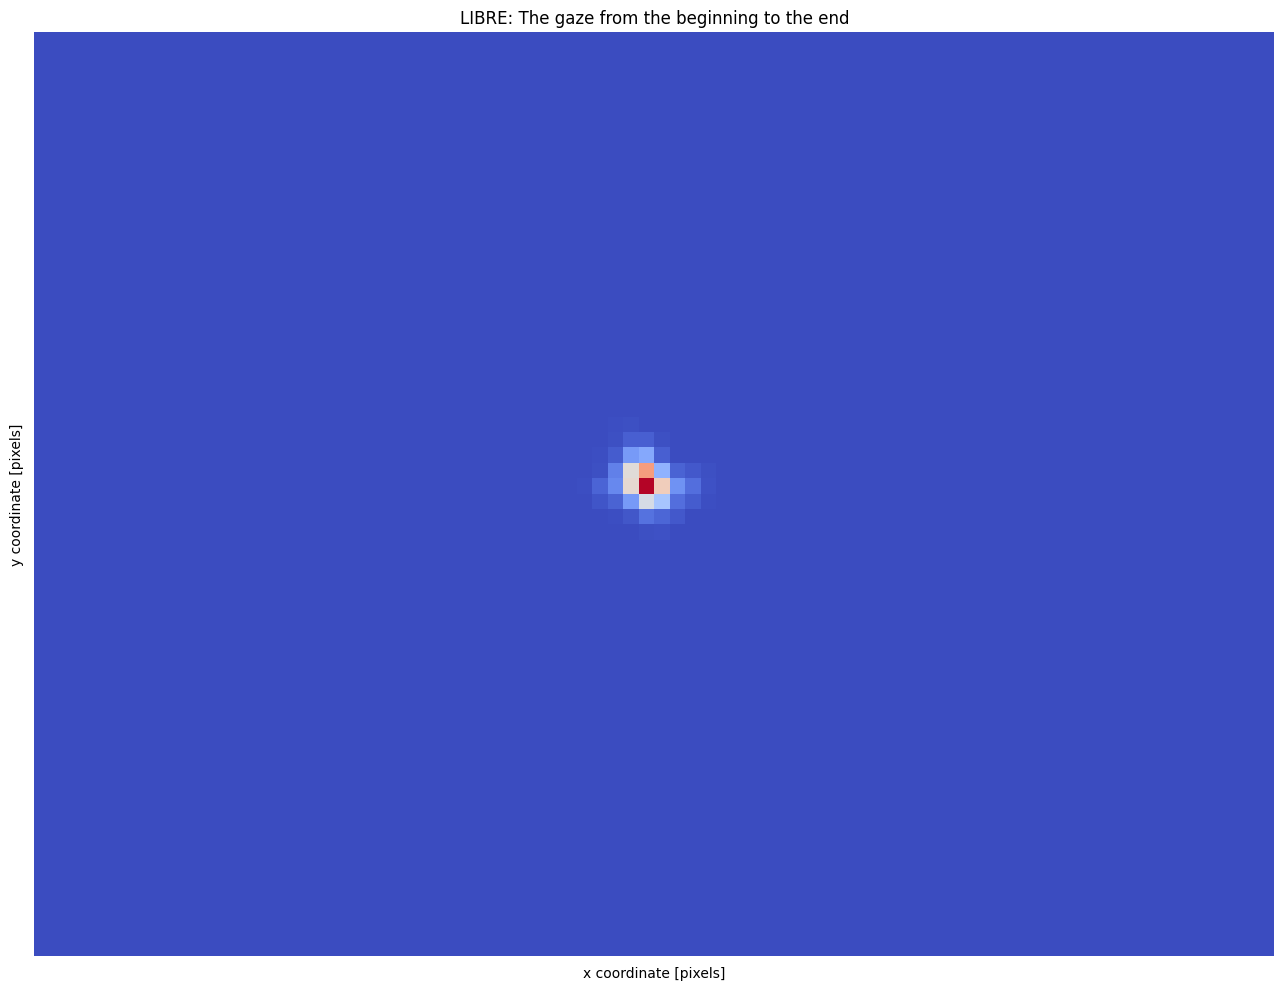

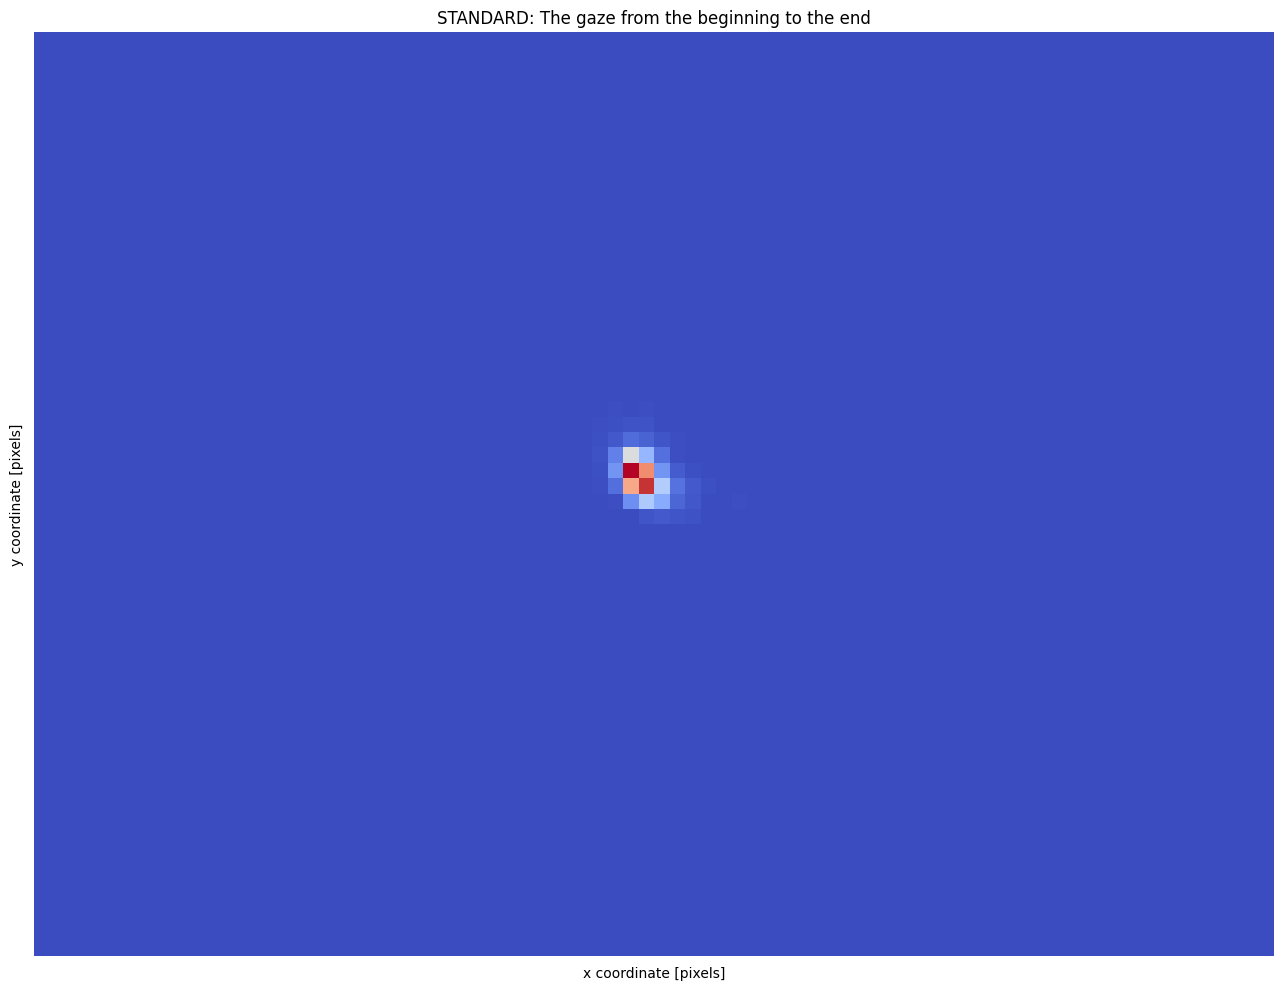

In [33]:
def eliminate_blink(coor_data, coor_recording, seq_name):
    coor_data = coor_data[coor_recording.blink < 1]
    coor_recording = coor_recording[coor_recording.blink < 1]
    print(f'After eliminating blinking: \nlen of coor_data_{seq_name} {len(coor_data)} \
      should be equal to len of coor_recording {len(coor_recording)}')
    return coor_data, coor_recording

coor_data_LIBRE,  coor_recording_LIBRE = eliminate_blink(coor_data_LIBRE, coor_recording_LIBRE, 'LIBRE')
coor_data_STANDARD,  coor_recording_STANDARD = eliminate_blink(coor_data_STANDARD, 
                                                               coor_recording_STANDARD, 'STANDARD')

import plot
plot.plot_heatmap_coordinate(coor_data_LIBRE, density=False, screen_size=size, 
                             title='LIBRE: The gaze from the beginning to the end')
plot.plot_heatmap_coordinate(coor_data_STANDARD, density=False, screen_size=size, 
                             title='STANDARD: The gaze from the beginning to the end')

### Preserving fixation

After preserving fixation: 
len of coor_data_LIBRE 612961       should be equal to len of coor_recording 612961
After preserving fixation: 
len of coor_data_STANDARD 373405       should be equal to len of coor_recording 373405


<AxesSubplot:title={'center':'STANDARD: The gaze from the beginning to the end'}, xlabel='x coordinate [pixels]', ylabel='y coordinate [pixels]'>

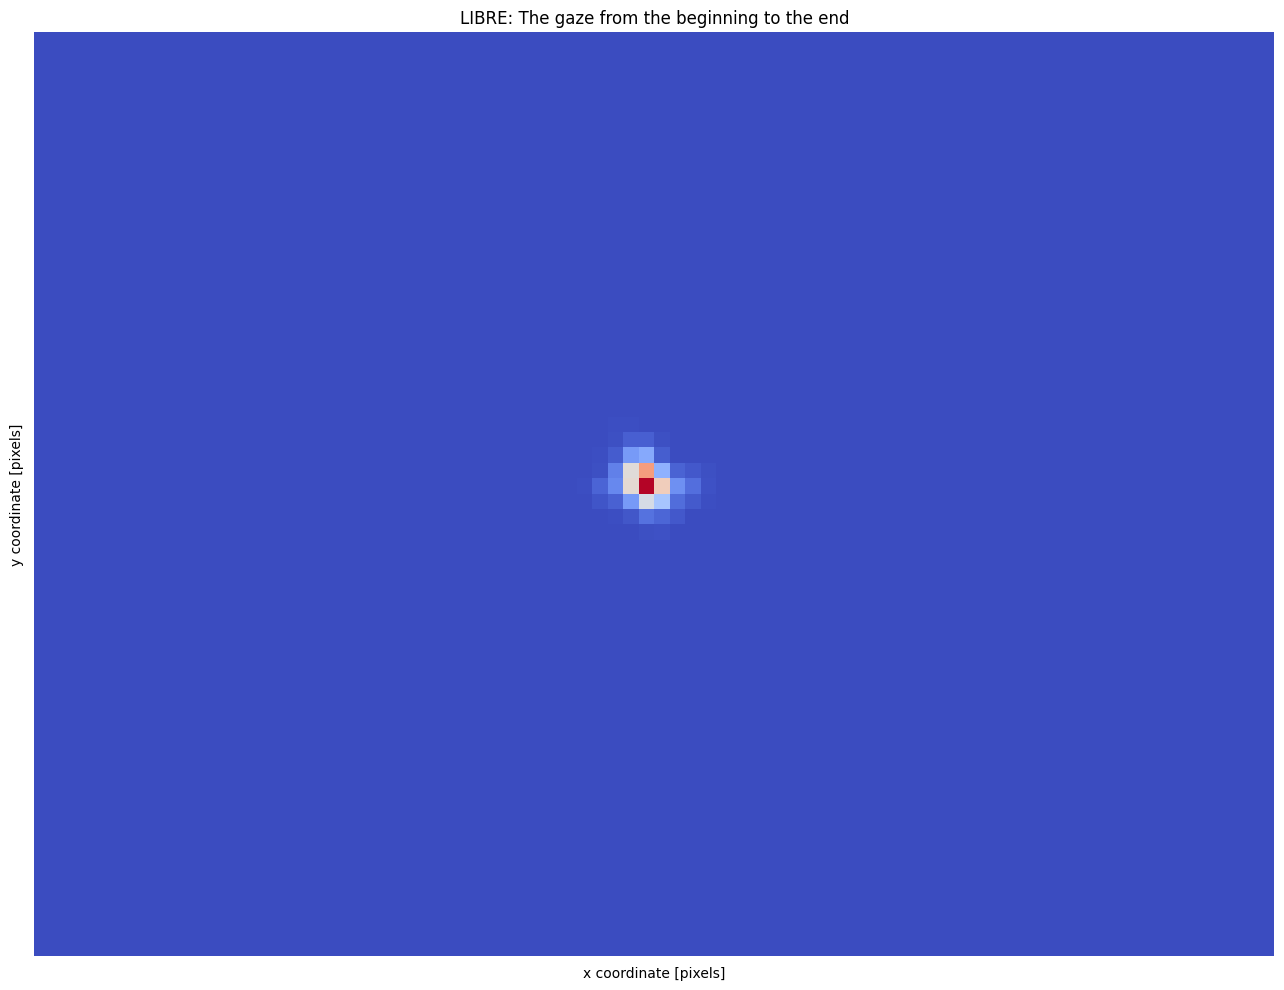

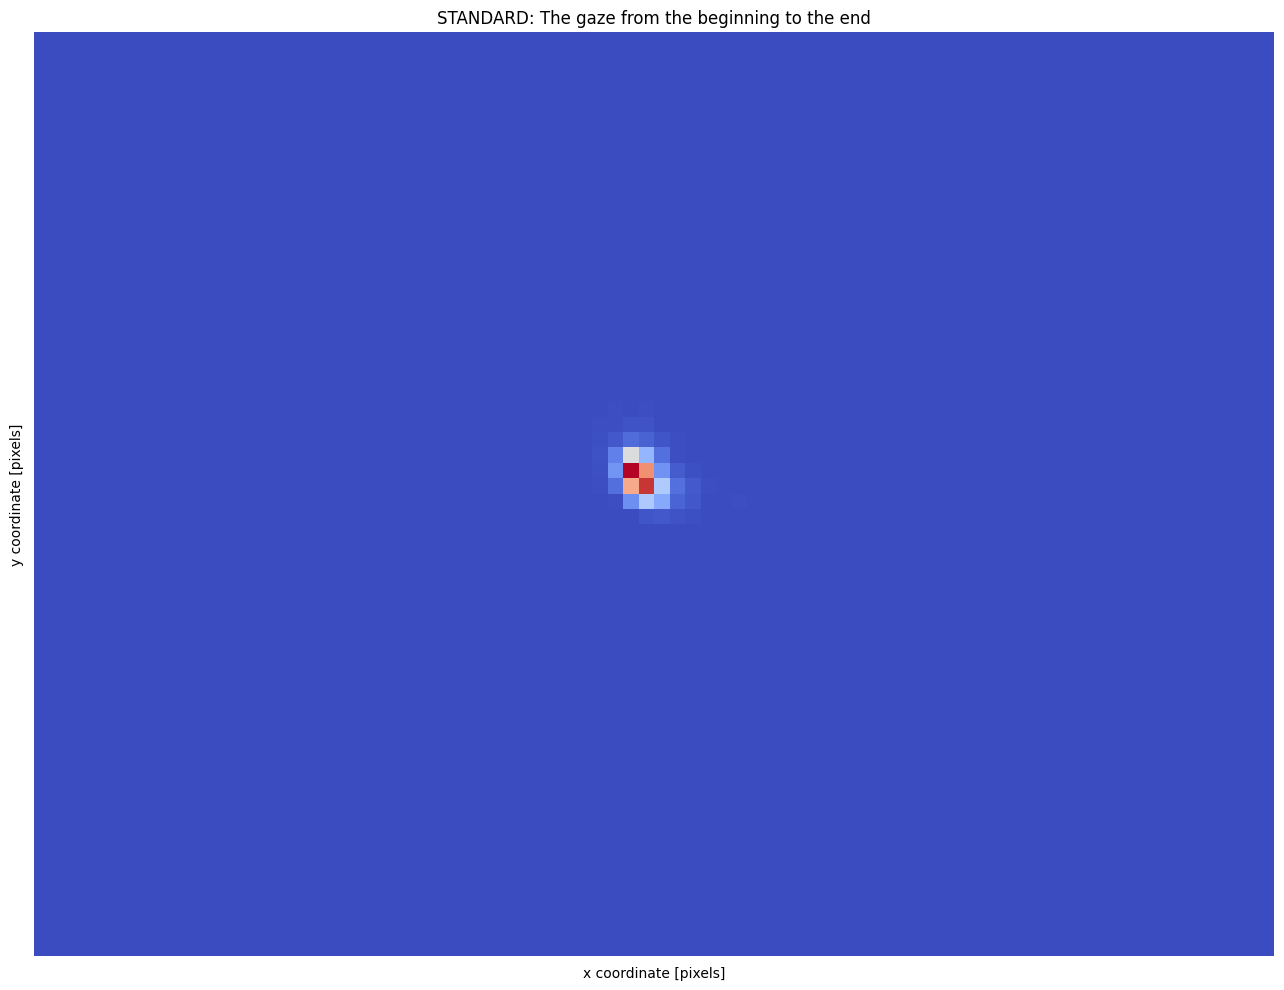

In [34]:
def preserve_fixation(coor_data, coor_recording, seq_name):
    coor_data = coor_data[coor_recording.fixation > 0]
    coor_recording = coor_recording[coor_recording.fixation > 0]
    print(f'After preserving fixation: \nlen of coor_data_{seq_name} {len(coor_data)} \
      should be equal to len of coor_recording {len(coor_recording)}')
    return coor_data, coor_recording

coor_data_LIBRE,  coor_recording_LIBRE = preserve_fixation(coor_data_LIBRE, coor_recording_LIBRE, 'LIBRE')
coor_data_STANDARD,  coor_recording_STANDARD = preserve_fixation(coor_data_STANDARD, 
                                                               coor_recording_STANDARD, 'STANDARD')

import plot
plot.plot_heatmap_coordinate(coor_data_LIBRE, density=False, screen_size=size, 
                             title='LIBRE: The gaze from the beginning to the end')
plot.plot_heatmap_coordinate(coor_data_STANDARD, density=False, screen_size=size, 
                             title='STANDARD: The gaze from the beginning to the end')

### Plot the gazing dots

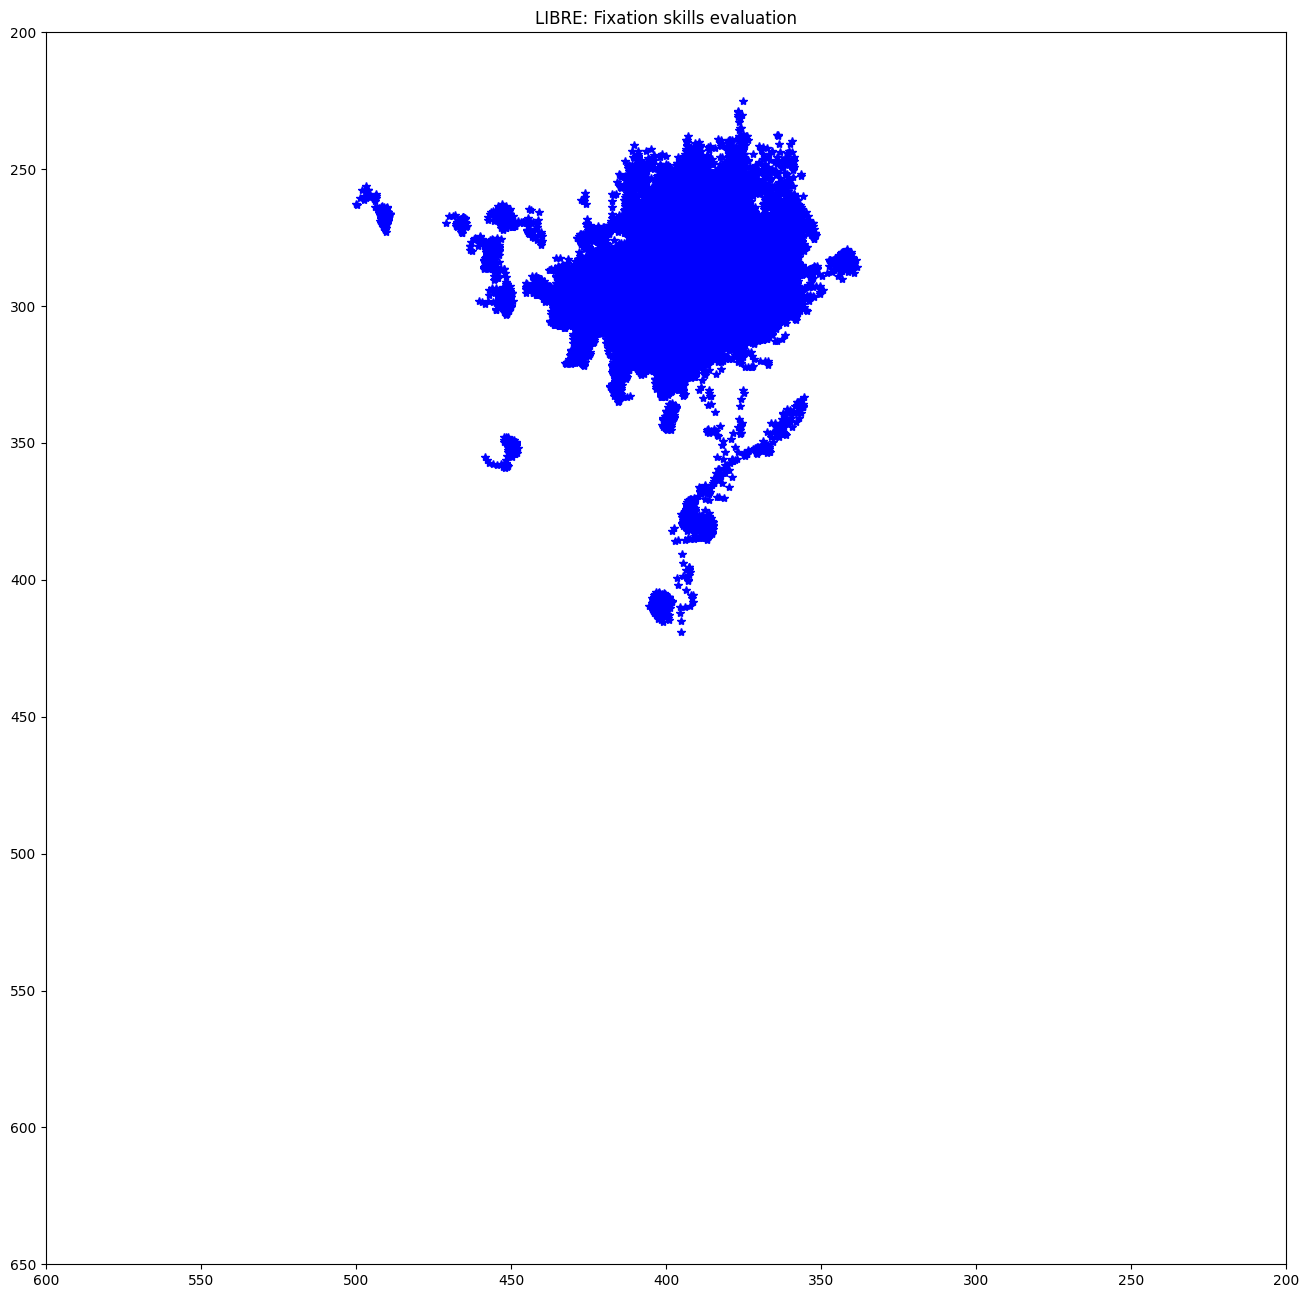

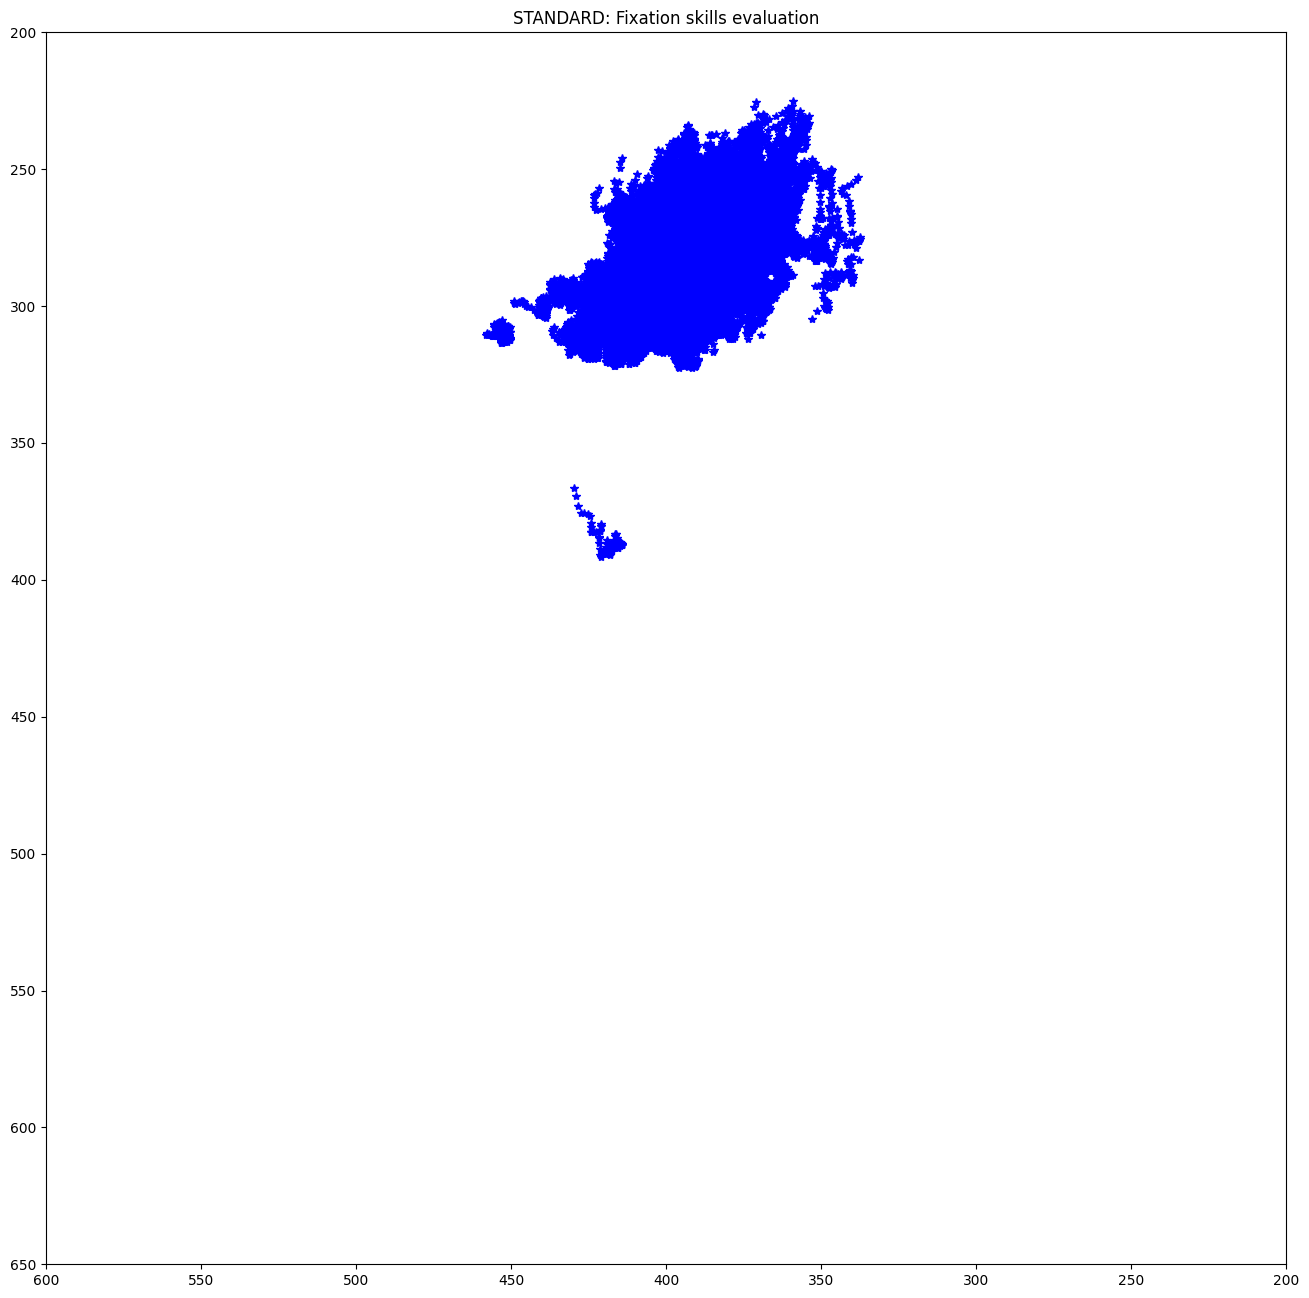

In [35]:
# Example data (replace with your actual data)
X_coord = coor_data_LIBRE['x_coordinate']
Y_coord = coor_data_LIBRE['y_coordinate']
fig, ax= plt.subplots(figsize=(16, 16))
# Plot the data, flipping X coordinates and using dots as markers
plt.plot(X_coord, Y_coord, '*', color='blue')
plt.xlim((200, 600))
plt.ylim((200, 650))
# Set plot title
plt.title('LIBRE: Fixation skills evaluation')
# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# ============================================================
# Example data (replace with your actual data)
X_coord = coor_data_STANDARD['x_coordinate']
Y_coord = coor_data_STANDARD['y_coordinate']
fig, ax= plt.subplots(figsize=(16, 16))
# Plot the data, flipping X coordinates and using dots as markers
plt.plot(X_coord, Y_coord, '*', color='blue')
plt.xlim((200, 600))
plt.ylim((200, 650))
# Set plot title
plt.title('STANDARD: Fixation skills evaluation')
# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()


By far, we initially cleaned data based on the inherent properties in the metadata from EyeLink. And we plotted the fixation evaluation,which show still distributed gazing dots instead of a clustered area. 

### Visual Angle

In [36]:
def cal_disp(coor_data, stand_x=0.15, stand_y=0.15):
    Disp_dict = {}
    X_coord = coor_data["x_coordinate"].values
    Y_coord = coor_data["y_coordinate"].values
    print('After cleaning nan, eminating data affected by blinking,\
            and preserving the fixation ')
    print(f'The length of X coordinate data: {len(X_coord)}')
    print(f'The length of Y coordinate data: {len(Y_coord)}')

    # Distance head-coil projector 102 cm  - size of an emmetrope eye varies from 2.1 cm to 2.7 cm 
    # (eye with a perfect vision)
    # in mm - this is common to both horizontal and angular rotation. 24 is 2.4cm which is the size of eye
    Cat1 =  24 + 1020
    print('check here is the eye size is defined manually?  can we extract the info from metadata?')

    # Depends on projector resolution, where 176px corresponds to 81.3 mm; 
    # so the formula becomes (Recorded_traj_px - center in px)*81.3/176
    # computation measures in mm， convert from px to mm
    # Transfer from pixel domain to mm, and shift the displacement to the center of screen
    Cat2_hor = abs(X_coord - 400)*81.3/176 ; 
    Cat2_ver = abs(Y_coord - 300)*62/137; 

    Hor_rot =  np.arctan(Cat2_hor/Cat1)
    Ver_rot =  np.arctan(Cat2_ver/Cat1)

    Disp_mm_eye_x =  np.tan(Hor_rot)*12 # 12: radius of the eye
    Disp_mm_eye_y =  np.tan(Ver_rot)*12

    
    Disp_dict['Disp_mm_eye'] = (Disp_mm_eye_x, Disp_mm_eye_y)

    med_x = np.median(Disp_mm_eye_x)
    print(f'med_x {med_x}')
    med_y = np.median(Disp_mm_eye_y)
    print(f'med_y {med_y}')
    Disp_dict['Disp_med'] = (med_x, med_y)
    # 0.5*std(Disp_mm_eye_y);

    # Subtract median
    Disp_mm_eye_x_minus_mx = Disp_mm_eye_x - med_x
    Disp_mm_eye_y_minus_my = Disp_mm_eye_y - med_y
    Disp_dict['Disp_mm_eye_minus_med'] = (Disp_mm_eye_x_minus_mx, Disp_mm_eye_y_minus_my)
    
    Ms_to_be_discarded_x_mask = ((Disp_mm_eye_x_minus_mx)>(stand_x) ) | ((Disp_mm_eye_x_minus_mx)<(-stand_x))
    Ms_to_be_discarded_y_mask = ((Disp_mm_eye_y_minus_my)>(stand_y))| ((Disp_mm_eye_y_minus_my)<(-stand_y))
    Disp_dict['Ms_to_be_discarded_mask'] = (Ms_to_be_discarded_x_mask, Ms_to_be_discarded_y_mask)
    Disp_dict['stand_xy'] = (stand_x, stand_y)
    return Disp_dict


In [37]:
Disp_dict_LIBRE = cal_disp(coor_data_LIBRE, stand_x=0.15, stand_y=0.15)
Disp_dict_STANDARD = cal_disp(coor_data_STANDARD, stand_x=0.15, stand_y=0.15)
print(Disp_dict_LIBRE.keys())

After cleaning nan, eminating data affected by blinking,            and preserving the fixation 
The length of X coordinate data: 612961
The length of Y coordinate data: 612961
check here is the eye size is defined manually?  can we extract the info from metadata?
med_x 0.043007477548055145
med_y 0.04317469948519696
After cleaning nan, eminating data affected by blinking,            and preserving the fixation 
The length of X coordinate data: 373405
The length of Y coordinate data: 373405
check here is the eye size is defined manually?  can we extract the info from metadata?
med_x 0.05256462276542448
med_y 0.05721956539978186
dict_keys(['Disp_mm_eye', 'Disp_med', 'Disp_mm_eye_minus_med', 'Ms_to_be_discarded_mask', 'stand_xy'])


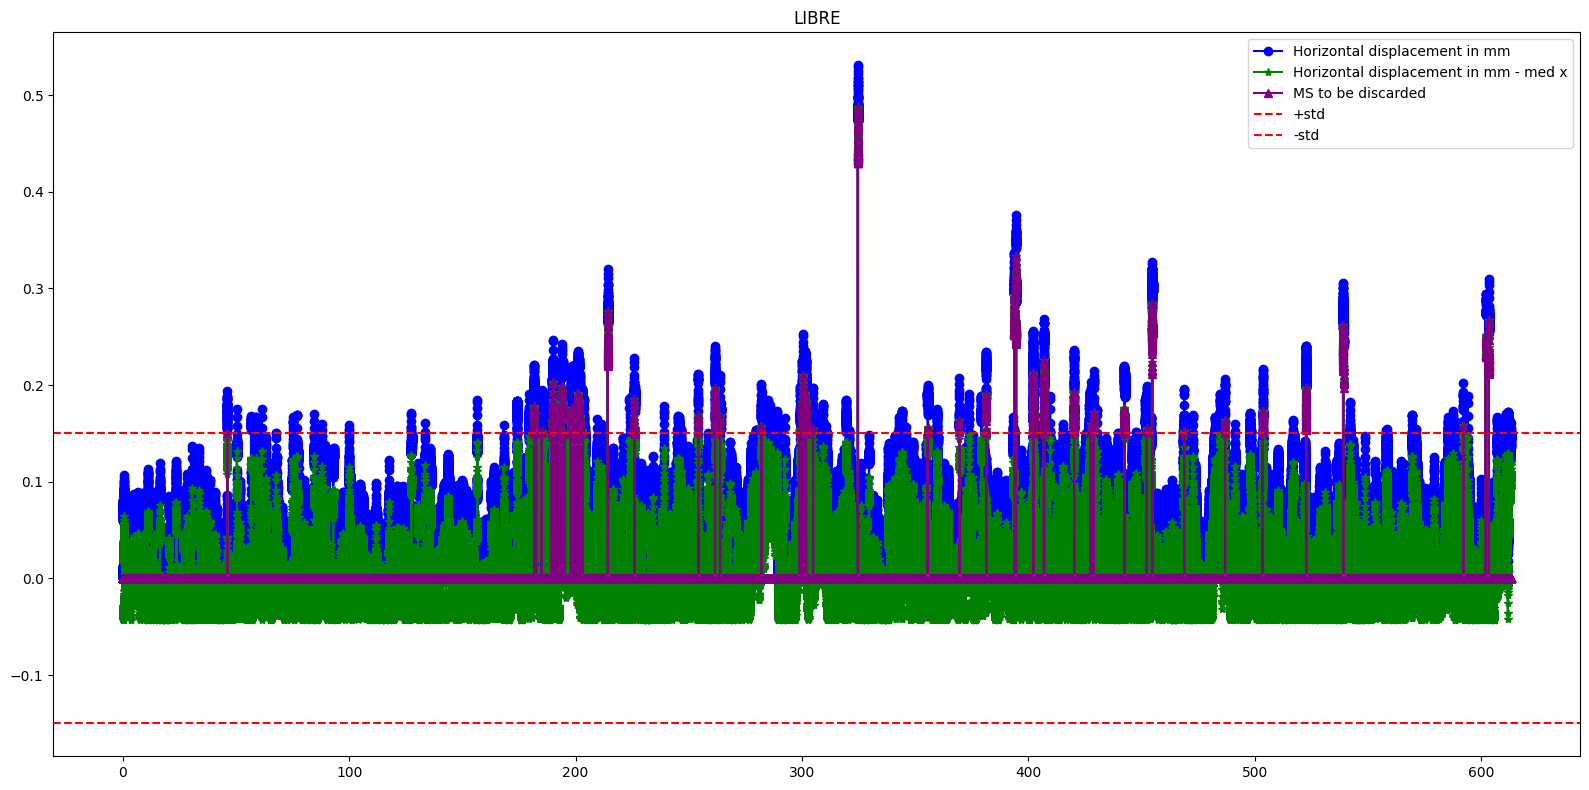

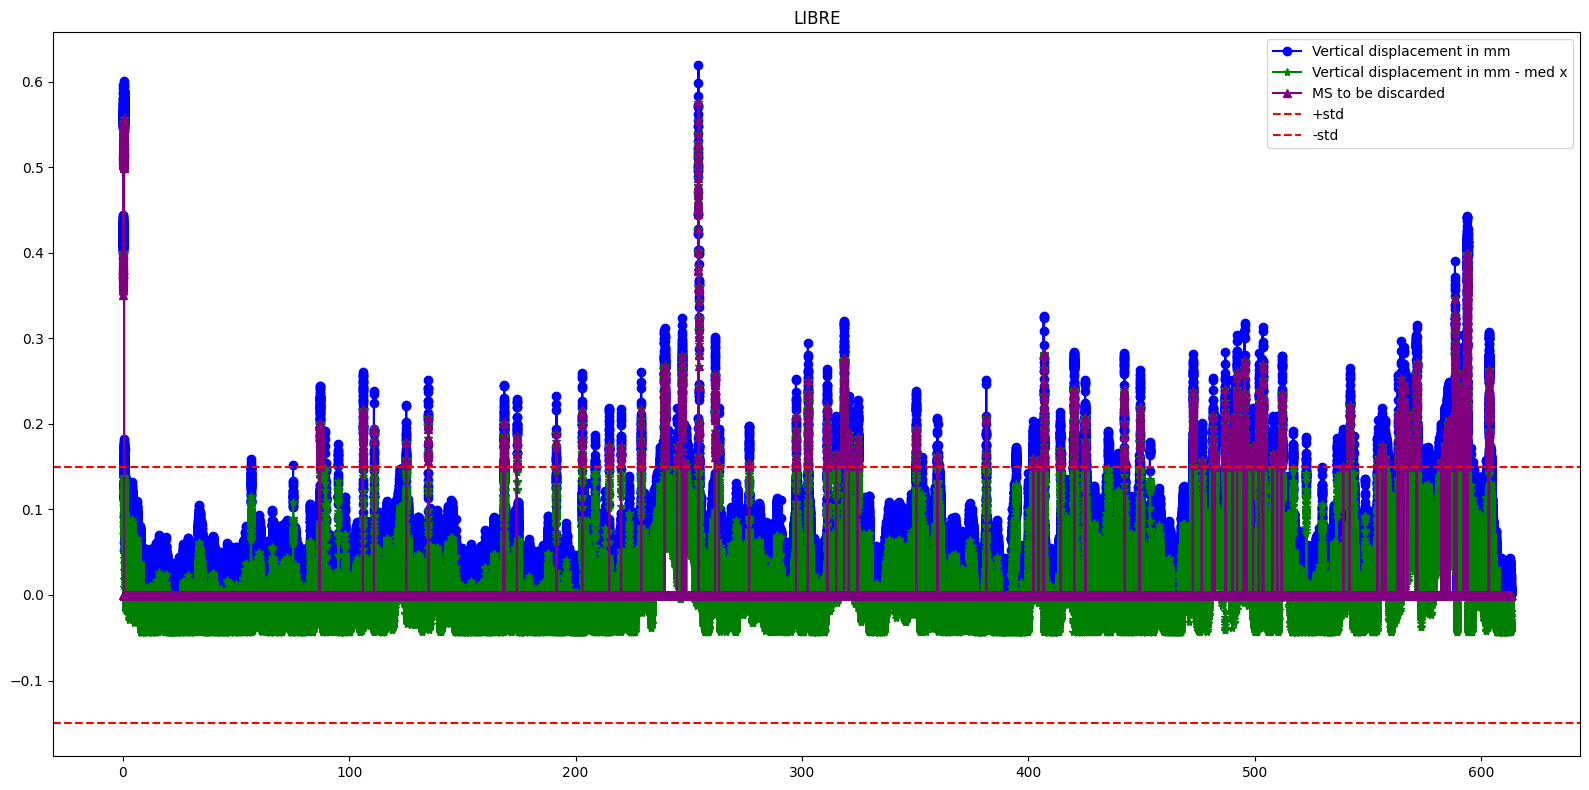

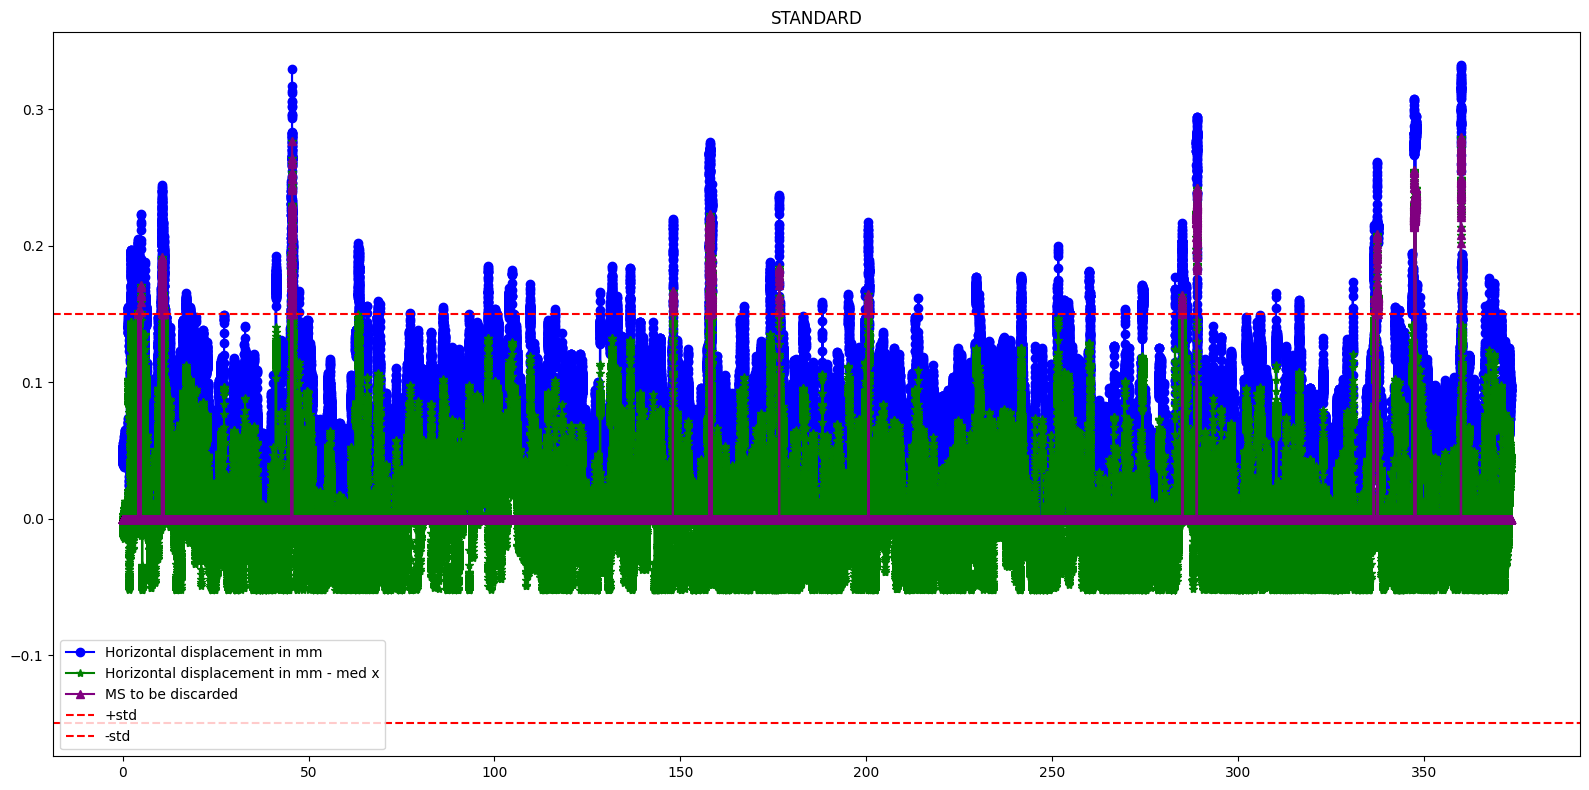

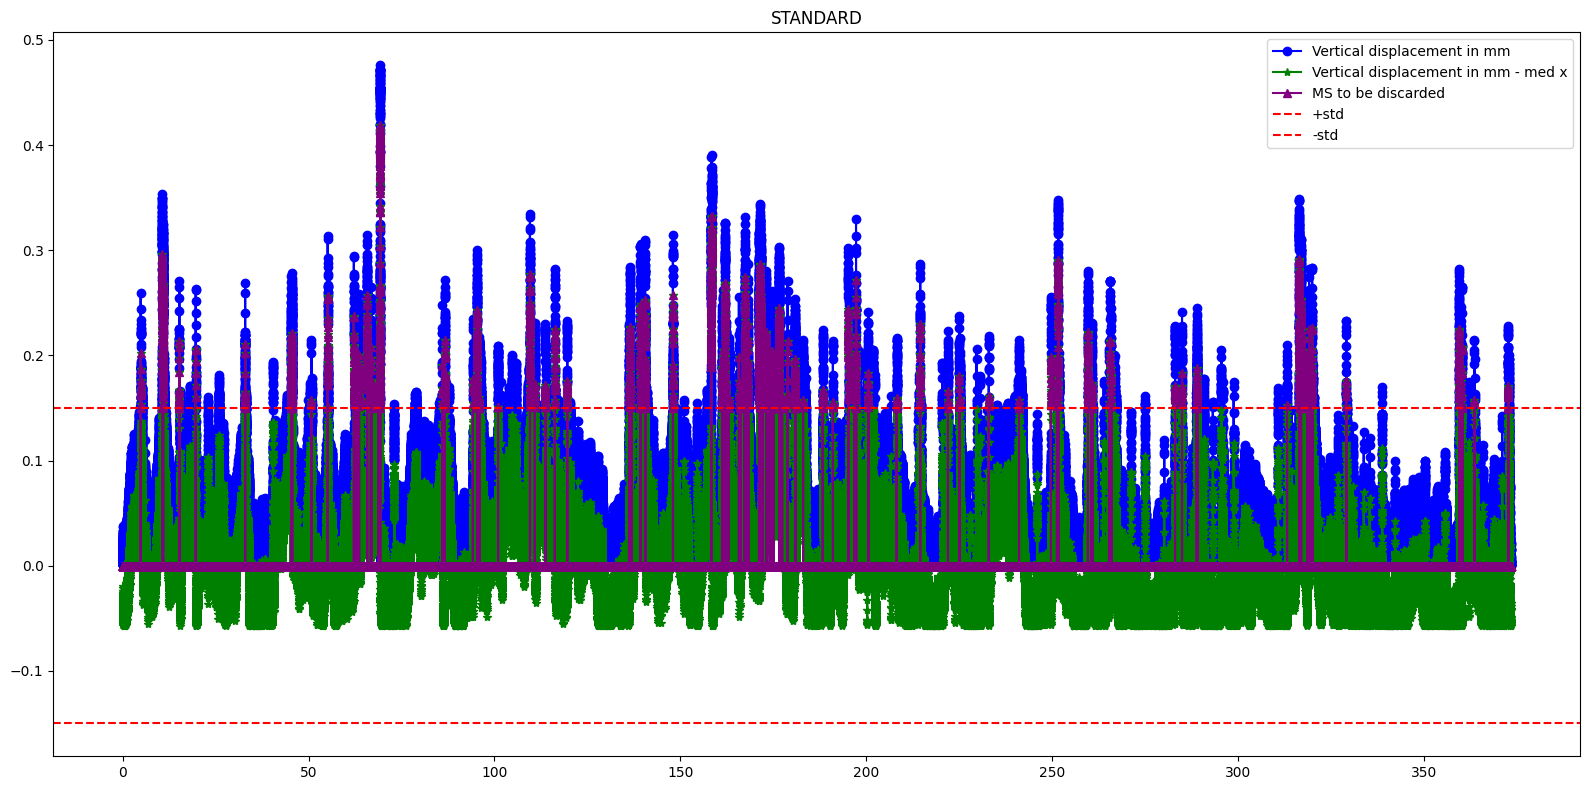

In [42]:
def plot_x_y_coord(Disp_dict, metadata, duration=None, start_sample=0, seq_name=None):
    Disp_mm_eye_x = Disp_dict['Disp_mm_eye'][0]
    Disp_mm_eye_y = Disp_dict['Disp_mm_eye'][1]
    Disp_mm_eye_x_minus_mx = Disp_dict['Disp_mm_eye_minus_med'][0]
    Disp_mm_eye_y_minus_my = Disp_dict['Disp_mm_eye_minus_med'][1]
    Ms_to_be_discarded_x_mask = Disp_dict['Ms_to_be_discarded_mask'][0]
    Ms_to_be_discarded_y_mask = Disp_dict['Ms_to_be_discarded_mask'][1]
    
    if duration == None:
        end_sample = len(Disp_mm_eye_x)
    else:    
        end_sample = duration*metadata["SamplingFrequency"]

    t_axis_xy = np.arange(start_sample, end_sample, 1)/metadata["SamplingFrequency"]

    # Horizontal direction!!!!!
    fig, ax= plt.subplots(figsize=(16, 8))
    
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_x[start_sample:end_sample],
        marker='o', color='blue',
        label="Horizontal displacement in mm"
    )
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_x_minus_mx[start_sample:end_sample],
        marker='*', color='green',
        label='Horizontal displacement in mm - med x'
    )

    if len(Ms_to_be_discarded_x_mask) != 0:
        ax.plot(
            t_axis_xy,
            Disp_mm_eye_x_minus_mx[start_sample:end_sample] * Ms_to_be_discarded_x_mask[start_sample:end_sample],
            marker='^', color='purple',
            label= 'MS to be discarded'
        )
    ax.axhline(y=Disp_dict['stand_xy'][0], color='r', linestyle='--', label='+std')
    ax.axhline(y=-Disp_dict['stand_xy'][0], color='r', linestyle='--', label='-std')
    ax.legend()
    ax.set_title(seq_name)
    plt.tight_layout()

    # Vertical direction!!!!!
    fig, ax= plt.subplots(figsize=(16, 8))
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_y[start_sample:end_sample],
        marker='o', color='blue',
        label="Vertical displacement in mm"
    )
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_y_minus_my[start_sample:end_sample],
        marker='*', color='green',
        label='Vertical displacement in mm - med x'
    )

    if len(Ms_to_be_discarded_y_mask) != 0:
        ax.plot(
            t_axis_xy,
            Disp_mm_eye_y_minus_my[start_sample:end_sample] * Ms_to_be_discarded_y_mask[start_sample:end_sample],
            marker='^', color='purple',
            label= 'MS to be discarded'
        )

    ax.axhline(y=Disp_dict['stand_xy'][1], color='r', linestyle='--', label='+std')
    ax.axhline(y=-Disp_dict['stand_xy'][1], color='r', linestyle='--', label='-std')
    ax.legend()
    ax.set_title(seq_name)
    plt.tight_layout()

plot_x_y_coord(Disp_dict_LIBRE, metadata, duration=None, start_sample=0, seq_name='LIBRE')
plot_x_y_coord(Disp_dict_STANDARD, metadata, duration=None, start_sample=0, seq_name='STANDARD')

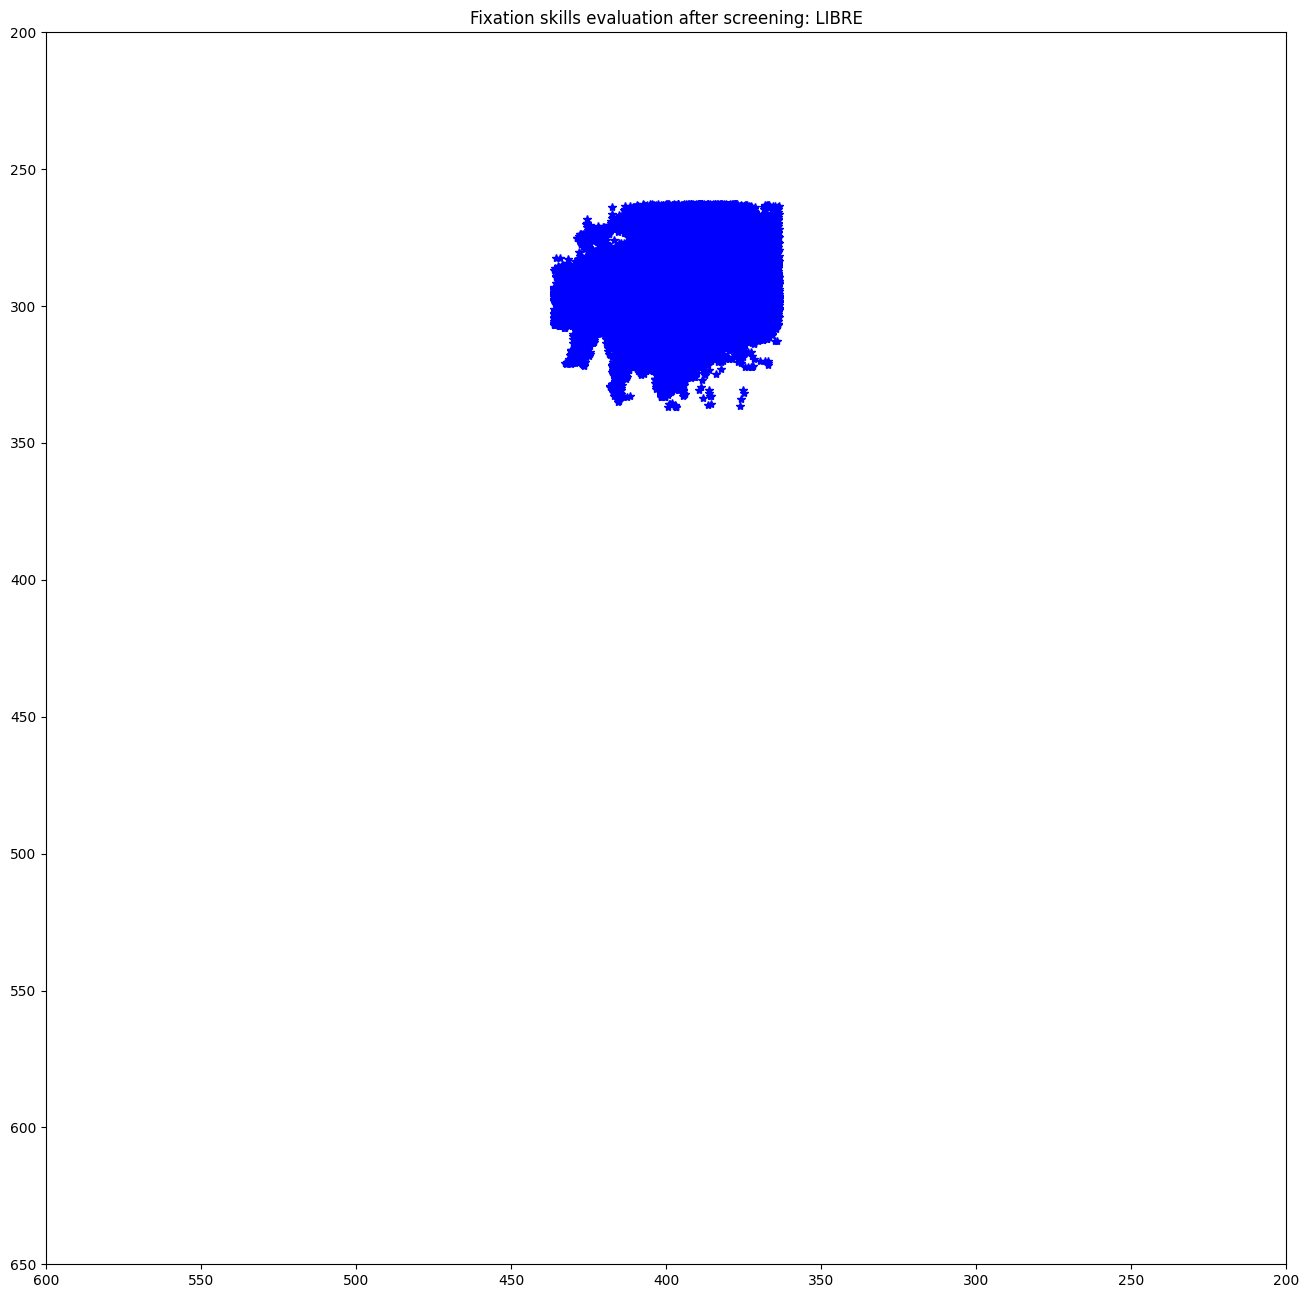

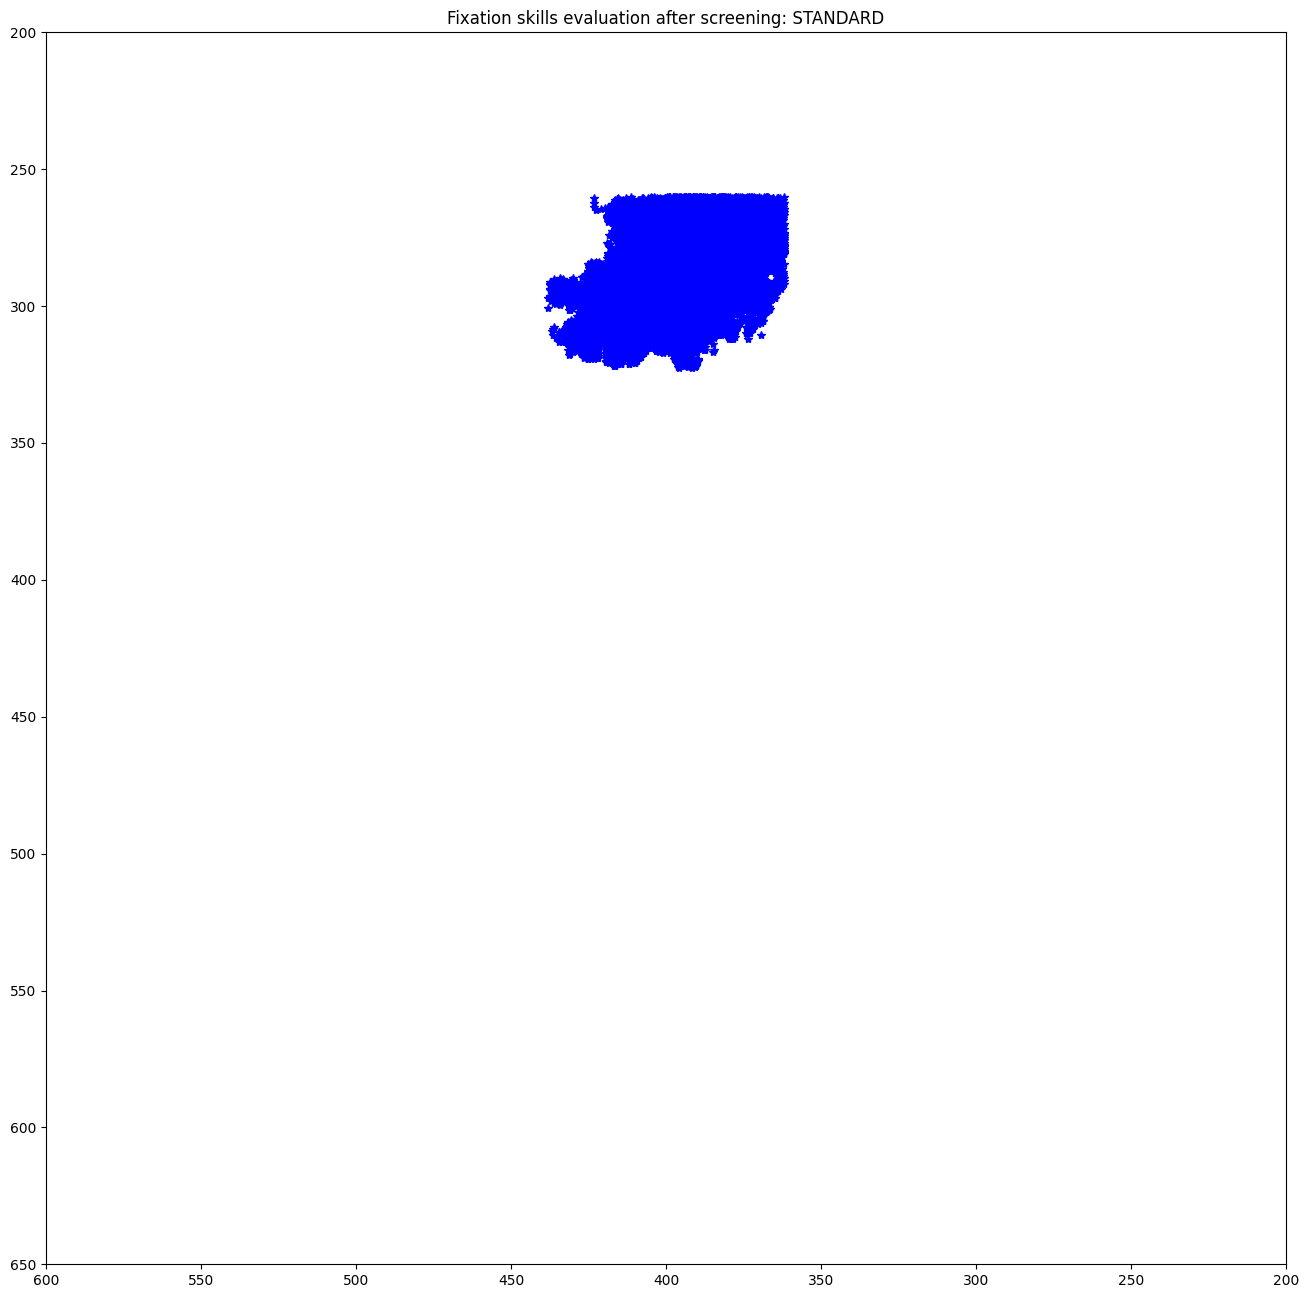

In [40]:
def filter_XY_coord(coor_data, Disp_dict, seq_name=None):
    X_coord = coor_data["x_coordinate"].values
    Y_coord = coor_data["y_coordinate"].values
    Ms_to_be_discarded_x_mask = Disp_dict['Ms_to_be_discarded_mask'][0]
    Ms_to_be_discarded_y_mask = Disp_dict['Ms_to_be_discarded_mask'][1]
    
    Combined_mask = ~(Ms_to_be_discarded_x_mask|Ms_to_be_discarded_y_mask)

    filtered_X_coord = X_coord * Combined_mask
    filtered_Y_coord = Y_coord * Combined_mask

    zero_mask = (filtered_X_coord == 0) & (filtered_Y_coord == 0)
    filtered_X_coord[zero_mask] = np.nan
    filtered_Y_coord[zero_mask] = np.nan

    # Example data (replace with your actual data)
    fig, ax= plt.subplots(figsize=(16, 16))
    # Plot the data, flipping X coordinates and using dots as markers
    plt.plot(filtered_X_coord, filtered_Y_coord, '*', color='blue')
    plt.xlim(200, 600)
    plt.ylim((200, 650))
    # Set plot title
    if seq_name is not None:
        plt.title(f'Fixation skills evaluation after screening: {seq_name}')
    else:     
        plt.title('Fixation skills evaluation after screening')

    # Reverse the direction of the Y-axis
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
    coor_data["x_coordinate"] = filtered_X_coord
    coor_data["y_coordinate"] = filtered_Y_coord
    
    return coor_data
    
    
filtered_coor_data_LIBRE = filter_XY_coord(coor_data_LIBRE, Disp_dict_LIBRE, 'LIBRE')
filtered_coor_data_STANDARD = filter_XY_coord(coor_data_STANDARD, Disp_dict_STANDARD, 'STANDARD')